In [1]:
from torch_geometric.datasets import Entities
import os.path as osp
import networkx as nx
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch_geometric as pyg

import numpy as np

import LPGNN

In [9]:
import importlib
importlib.reload(module=LPGNN)

<module 'LPGNN' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/__init__.py'>

In [40]:
4//5

0

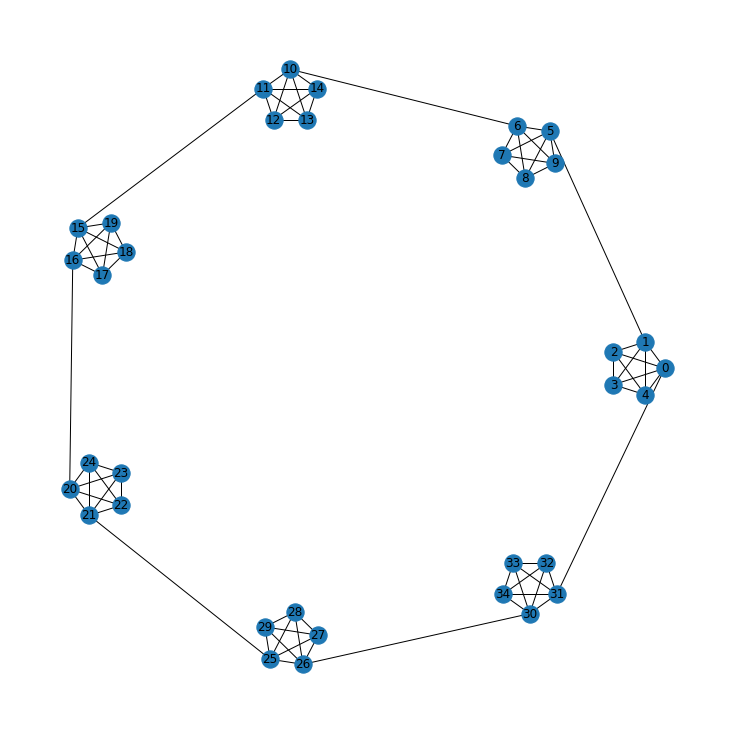

In [46]:
#G_nx = nx.barabasi_albert_graph(200, m=4)
num_cliques = 7
clique_size = 5
r = 0.1
G_nx = nx.ring_of_cliques(num_cliques, clique_size)
G_nx.graph['pos'] = {}
for node in G_nx.nodes:
    c = node // clique_size
    theta_c = 2*np.pi/num_cliques*c
    x_c = np.cos(theta_c)
    y_c = np.sin(theta_c)
    i = node % clique_size
    theta_i = 2*np.pi/clique_size*i + np.pi/4*c
    x_i = r*np.cos(theta_i)
    y_i = r*np.sin(theta_i)
    G_nx.graph['pos'][node] = np.array([x_c+x_i, y_c+y_i])
fig = plt.figure(figsize=(10, 10))
nx.draw(G_nx, pos=G_nx.graph['pos'], with_labels=True)

In [47]:
data = pyg.utils.from_networkx(G_nx)
#data.x = torch.Tensor( np.transpose([list(nx.degree_centrality(G_nx).values())]) )
data.x = torch.Tensor( np.transpose([np.zeros(G_nx.number_of_nodes())]) )
data.x[0:5] = 1
#data.x = torch.Tensor([i for i in torch.ones()])

data.neg_edge_index = pyg.utils.negative_sampling(data.edge_index)

#train, val, test = DataSetup.TrainTestSplit(data, test_ratio=0, val_ratio=0, neg_samples=True)

In [54]:
graphSage = pyg.nn.GraphSAGE(in_channels=data.num_features, hidden_channels=16, out_channels=data.num_features*4, num_layers=3)
optimizer = torch.optim.SGD(graphSage.parameters(), lr=0.01)

In [49]:
# Convert the models output to a logit matrix
def decode(z, pos_edge_index, neg_edge_index):
    edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
    #logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    return logits

def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] where the number of ones is equal to the length of 
    # pos_edge_index and the number of zeros is equal to the length of neg_edge_index
    
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    #E = pos_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


In [55]:
device = 'cpu'
link_labels = get_link_labels(data.edge_index, data.neg_edge_index)

In [56]:
Z = [data.x]

for i in range(50):
    graphSage.train()
    optimizer.zero_grad()

    z = graphSage.forward(data.x, data.edge_index) #forward
    Z.append(z)
    link_logits = decode(z, data.edge_index, data.neg_edge_index) # decode

    loss = torch.nn.functional.binary_cross_entropy_with_logits(link_logits, link_labels)
    #loss = torch.nn.
    #probs = z @ z.T
    #probs = nn.functional.normalize(torch.concat((probs[train_data.pos_edge_label_index[0], train_data.pos_edge_label_index[1]],
                                                    #probs[train_data.neg_edge_label_index[0], train_data.neg_edge_label_index[1]])), dim=0)
    #loss = nn.functional.binary_cross_entropy(probs, link_labels)
    loss.backward()
    optimizer.step()

In [52]:
import importlib
importlib.reload(module=LPGNN.visualization.gnn_attr_passing)

<module 'LPGNN.visualization.gnn_attr_passing' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/visualization/gnn_attr_passing.py'>

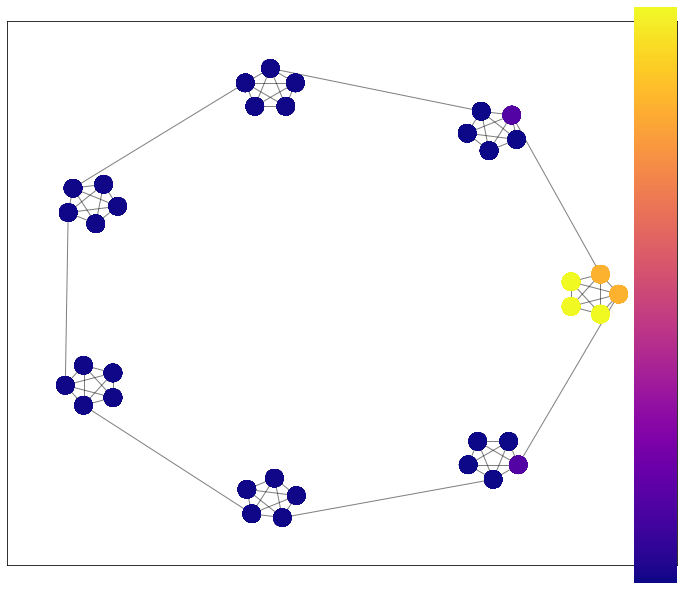

In [57]:
LPGNN.visualization.gnn_attr_passing.animate_graph_with_attrs(G=G_nx, attrs_list=Z, savename='Ring_of_cliques/')